In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import os

# ---------------------------------------------------
# 0. Load  dataset
# ---------------------------------------------------
FILE_PATH = "/kaggle/input/mf-data/MF.csv"
df = pd.read_csv(FILE_PATH)

# ---------------------------------------------------
# 1. Filter out non-positive market values
# ---------------------------------------------------
df = df[df["MarketValue"] > 0].copy()

# ---------------------------------------------------
# 2. Log-transform MarketValue (optional)
# ---------------------------------------------------
df['LogMarketValue'] = np.log(df['MarketValue'])

# ---------------------------------------------------
# 3. Feature selection
# ---------------------------------------------------
selected_features = [
    'Overall rating',
    'Potential',
    'Minutes',
    'Goals + Assists',
    'Value',
    'Wage',
    'Vision',
    'xAG: Exp. Assisted Goals',
    'Progressive Passes',
    'Progressive Carries',
    'xG: Expected Goals',
    'Dribbling',
    'Ball control',
    'Curve',
    'Volleys',
    'Crossing',
    'Stamina',
    'Sprint speed',
    'Reactions',
    'Balance',
    'Interceptions',
    'Blocks',
    'Tkl+Int',
    'Finishing',
    'Shot power',
    'team_score',
    'league_score',
    'country_score',
    'Total movement'
]

# ---------------------------------------------------
# 4. Prepare X and y
# ---------------------------------------------------
X = df[selected_features]
y = df['MarketValue']
value_feature = df['Value']  # we need it for the extra filtering

# ---------------------------------------------------
# 5. Handle missing values
# ---------------------------------------------------
X = X.fillna(X.median())

# ---------------------------------------------------
# 6. Outlier Removal
# ---------------------------------------------------
# Step 1: Z-Score based cleaning on MarketValue
z_scores = zscore(y)
threshold = 2.5  # tighter threshold

mask_zscore = np.abs(z_scores) < threshold

X = X[mask_zscore].reset_index(drop=True)
y = y[mask_zscore].reset_index(drop=True)
value_feature = value_feature[mask_zscore].reset_index(drop=True)

# Step 2: Value vs MarketValue logic-based cleaning
mask_value_vs_marketvalue = ~(
    ((y > 1.5 * value_feature) | (value_feature > 1.5 * y))
)


X_clean = X[mask_value_vs_marketvalue].reset_index(drop=True)
y_clean = y[mask_value_vs_marketvalue].reset_index(drop=True)
value_feature_clean = value_feature[mask_value_vs_marketvalue].reset_index(drop=True)

print(f"✅ After both outlier removals: {X_clean.shape[0]} samples remaining.")

# ---------------------------------------------------
# 7. Rebuild cleaned df
# ---------------------------------------------------
df_clean = X_clean.copy()
df_clean['MarketValue'] = y_clean
df_clean['Value'] = value_feature_clean

# ---------------------------------------------------
# 8. Define Segment boundaries (low, mid, high)
# ---------------------------------------------------
bins = [0, 1e6, 20e6, float("inf")]
labels = ["low", "mid", "high"]

df_clean["Segment"] = pd.cut(df_clean["MarketValue"], bins=bins, labels=labels)

# ---------------------------------------------------
# 9. Split into segments
# ---------------------------------------------------
df_low  = df_clean[df_clean["Segment"] == "low"].copy()
df_mid  = df_clean[df_clean["Segment"] == "mid"].copy()
df_high = df_clean[df_clean["Segment"] == "high"].copy()

print(f"Low segment:  {len(df_low)} players")
print(f"Mid segment:  {len(df_mid)} players")
print(f"High segment: {len(df_high)} players")
# ---------------------------------------------------
# 1. Split X and log(y) into train/test
# ---------------------------------------------------
X = df_clean[selected_features]
y_raw = df_clean['MarketValue'] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)
y_log = np.log(df_clean['MarketValue'])

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

✅ After both outlier removals: 1906 samples remaining.
Low segment:  400 players
Mid segment:  1350 players
High segment: 156 players


## MArket value prediction (normal scale) performance:
### 📊 XGBoost Model Performance (Fixed Params):
- MAE: 1014038.606
- RMSE: 1995469.004
- R²: 0.944
- RMSPE: 44.778%

⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (Fixed Params):
MAE: 1014038.606
RMSE: 1995469.004
R²: 0.944
RMSPE: 44.778%


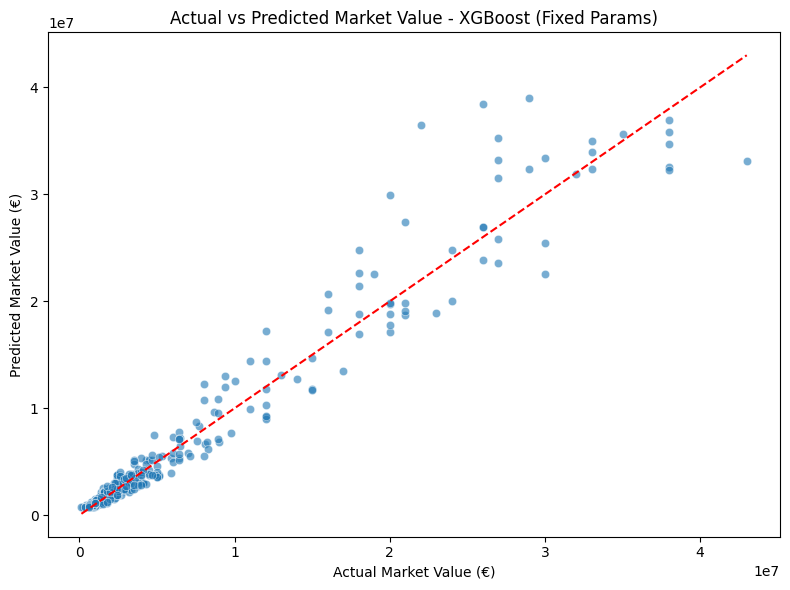

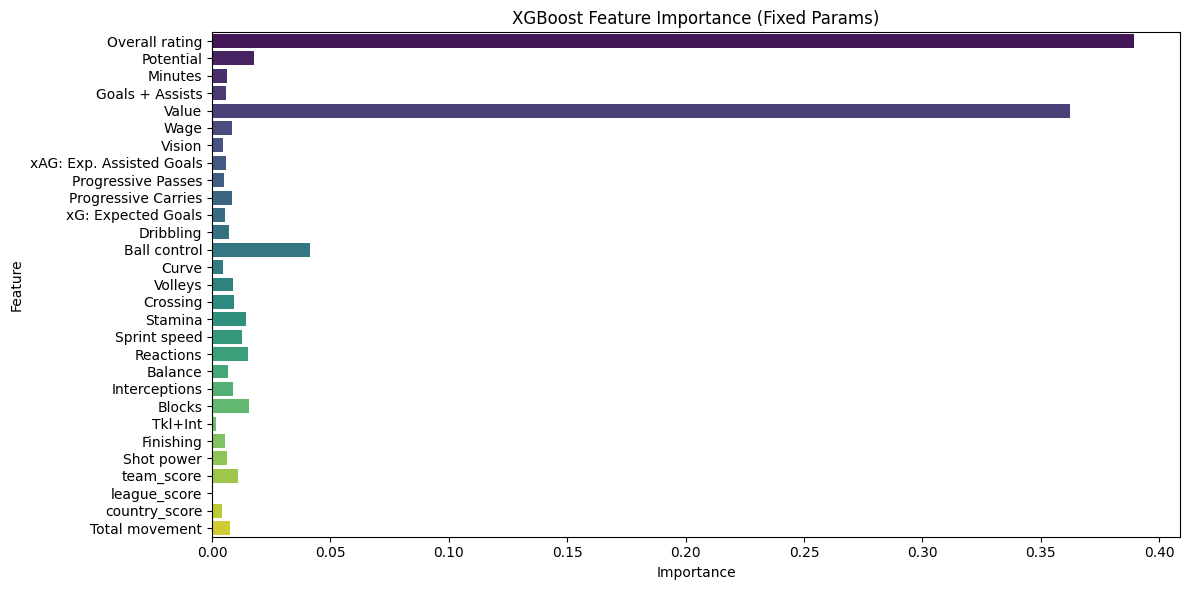

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd


# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if isinstance(X_train[col].iloc[0], (pd.Series, pd.DataFrame, list, dict))]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train XGBoost with fixed parameters
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.9,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    subsample=0.9
)

xgb_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred = xgb_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 XGBoost Model Performance (Fixed Params):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# 7. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_fixed_params.png"))
plt.show()

# ---------------------------------------------------
# 8. Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_fixed_params.png"))
plt.show()


In [8]:
# ---------------------------------------------------
# Print Sample of Actual vs Predicted Market Values
# ---------------------------------------------------
sample_results = pd.DataFrame({
    'Actual Market Value (€)': y_test.values,
    'Predicted Market Value (€)': np.round(y_pred).astype(int)
})

# Show first 15 rows (you can adjust)
print("\n🧪 Sample of Actual vs Predicted Market Values:")
print(sample_results.head(15))



🧪 Sample of Actual vs Predicted Market Values:
    Actual Market Value (€)  Predicted Market Value (€)
0                   1600000                     1471001
1                   1900000                     2570113
2                   4800000                     7472725
3                    900000                     1057732
4                    640000                      731203
5                  16000000                    17160502
6                    320000                      770910
7                   1800000                     1314448
8                   1800000                     2202226
9                   3000000                     2425892
10                 30000000                    25407396
11                   870000                      938503
12                  2400000                     3750858
13                  5100000                     3717594
14                 19000000                    22536716


## Log market value predictoins:
### 📊 XGBoost Model Performance (LOG MarketValue):
- MAE (log): 0.180
- RMSE (log): 0.217
- R² (log): 0.967
- RMSPE (log): 1.484%

## 📊 XGBoost Model Performance (MarketValue € back-transformed):
- MAE (€): 986301.326
- RMSE (€): 1972812.686
- R² (€): 0.945
- RMSPE (€): 22.229%

✅ Data Split - X_train: (1524, 29), X_test: (382, 29)
⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (LOG MarketValue):
MAE (log): 0.180
RMSE (log): 0.217
R² (log): 0.967
RMSPE (log): 1.484%

📊 XGBoost Model Performance (MarketValue € back-transformed):
MAE (€): 986301.326
RMSE (€): 1972812.686
R² (€): 0.945
RMSPE (€): 22.229%


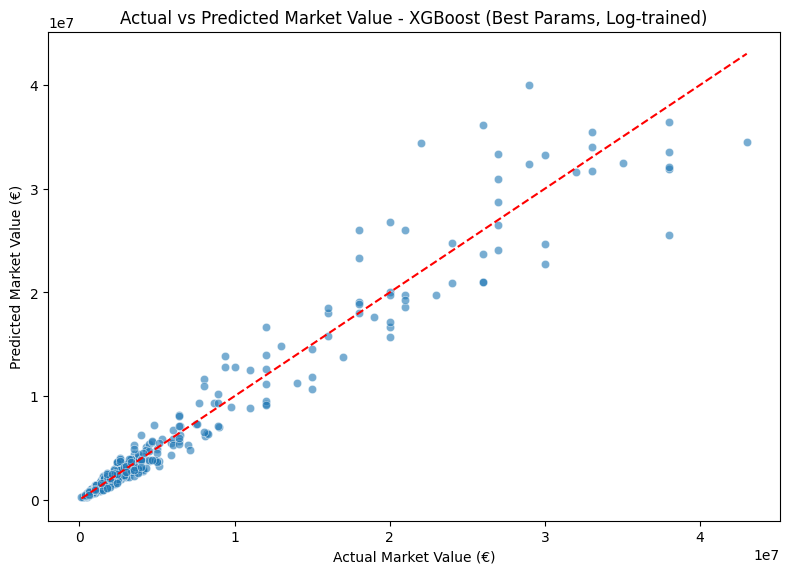

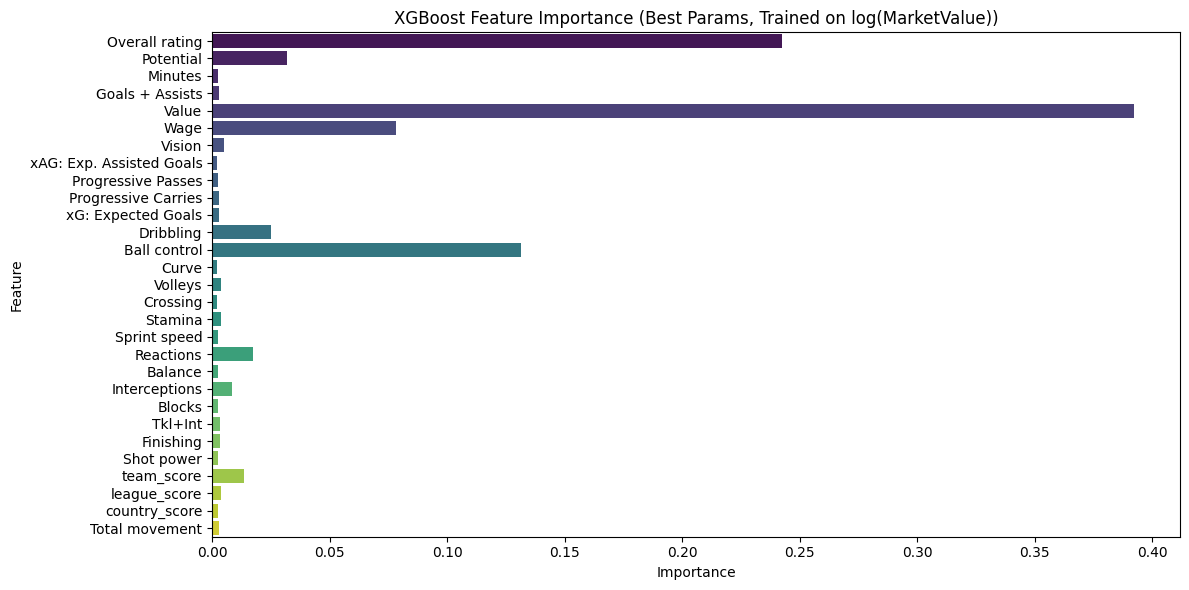

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Split X and log(y) into train/test
# ---------------------------------------------------
X = df_clean[selected_features]
y_raw = df_clean['MarketValue']


print(f"✅ Data Split - X_train: {X_train.shape}, X_test: {X_test.shape}")

# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train XGBoost model (Best Parameters)
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    subsample=0.7
)

xgb_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred_log = xgb_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate on log scale
# ---------------------------------------------------
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log))

print("\n📊 XGBoost Model Performance (LOG MarketValue):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE (log): {rmspe_log:.3f}%")

# ---------------------------------------------------
# 7. Back-transform predictions and evaluate on € scale
# ---------------------------------------------------
y_test_euros = np.exp(y_test_log)
y_pred_euros = np.exp(y_pred_log)

mae_euros = mean_absolute_error(y_test_euros, y_pred_euros)
mse_euros = mean_squared_error(y_test_euros, y_pred_euros)
rmse_euros = np.sqrt(mse_euros)
r2_euros = r2_score(y_test_euros, y_pred_euros)
rmspe_euros = rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros))

print("\n📊 XGBoost Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mae_euros:.3f}")
print(f"RMSE (€): {rmse_euros:.3f}")
print(f"R² (€): {r2_euros:.3f}")
print(f"RMSPE (€): {rmspe_euros:.3f}%")

# ---------------------------------------------------
# 8. Plot: Actual vs Predicted (on raw €)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Best Params, Log-trained)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_best_params_logtrain.png"))
plt.show()

# ---------------------------------------------------
# 9. Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_best_params_logtrain.png"))
plt.show()


## RF market value prediction model Random Forest Model Performance (Fixed Best Parameters):
- MAE (€): 970032.577
- RMSE (€): 1906675.064
- R²: 0.949
- RMSPE: 30.179%
  

⚠️ Dropping corrupted/nested columns: []

📊 Random Forest Model Performance (Fixed Best Parameters):
MAE (€): 970032.577
RMSE (€): 1906675.064
R²: 0.949
RMSPE: 30.179%


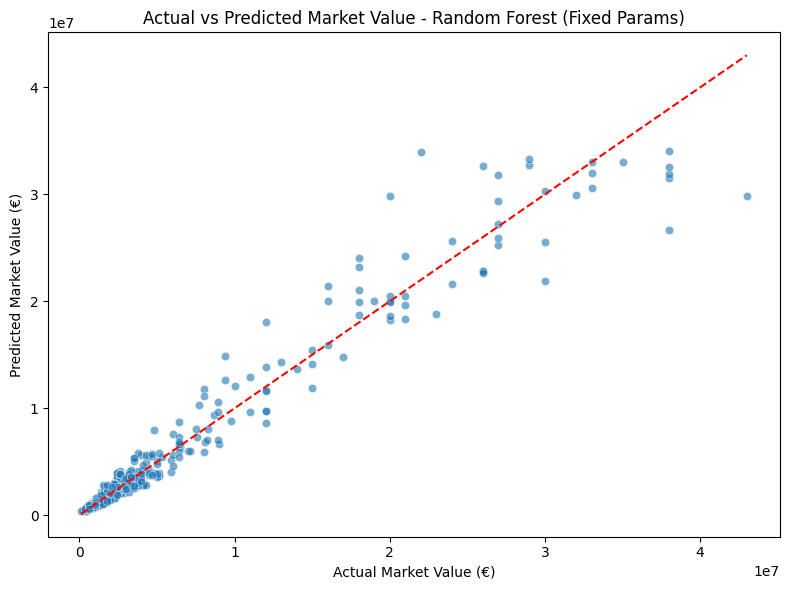

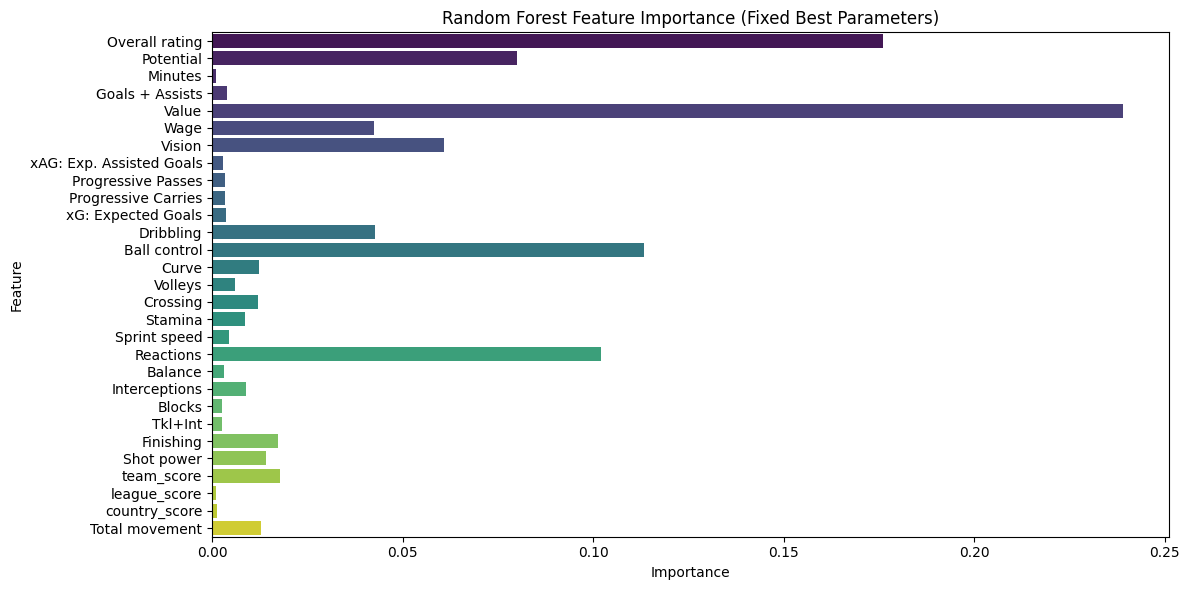

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train Random Forest (Fixed Best Parameters)
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200
)

rf_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred = rf_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 Random Forest Model Performance (Fixed Best Parameters):")
print(f"MAE (€): {mae:.3f}")
print(f"RMSE (€): {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# 7. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Random Forest (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_fixed_params.png"))
plt.show()

# ---------------------------------------------------
# 8. Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Fixed Best Parameters)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_fixed_params.png"))
plt.show()


## Random Forset log:
### 📊 Random Forest Model Performance (LOG MarketValue):
- MAE (log): 0.190
- RMSE (log): 0.229
- R² (log): 0.963
- RMSPE (log): 1.573%

### 📊 Random Forest Model Performance (MarketValue € back-transformed):
- MAE (€): 1006397.619
- RMSE (€): 2013129.306
- R² (€): 0.943
- RMSPE (€): 23.428%

✅ Data Split - X_train: (1524, 29), X_test: (382, 29)

📊 Random Forest Model Performance (LOG MarketValue):
MAE (log): 0.190
RMSE (log): 0.229
R² (log): 0.963
RMSPE (log): 1.573%

📊 Random Forest Model Performance (MarketValue € back-transformed):
MAE (€): 1006397.619
RMSE (€): 2013129.306
R² (€): 0.943
RMSPE (€): 23.428%


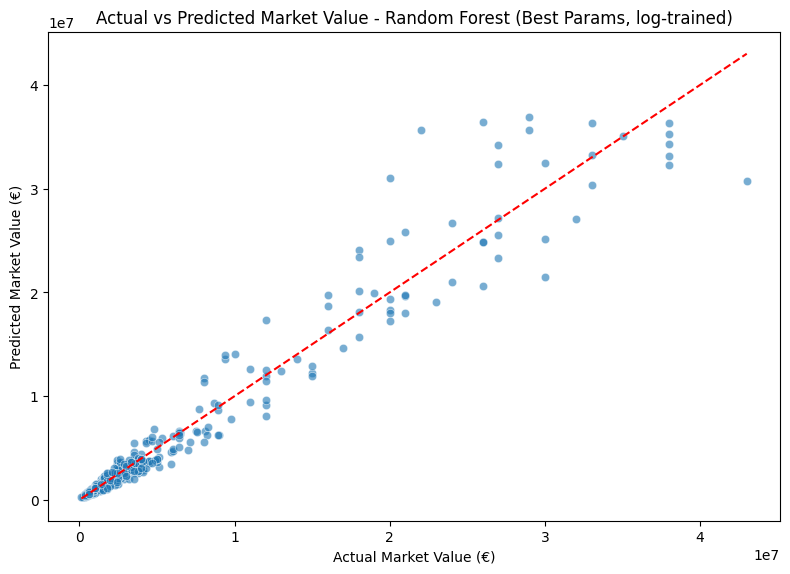

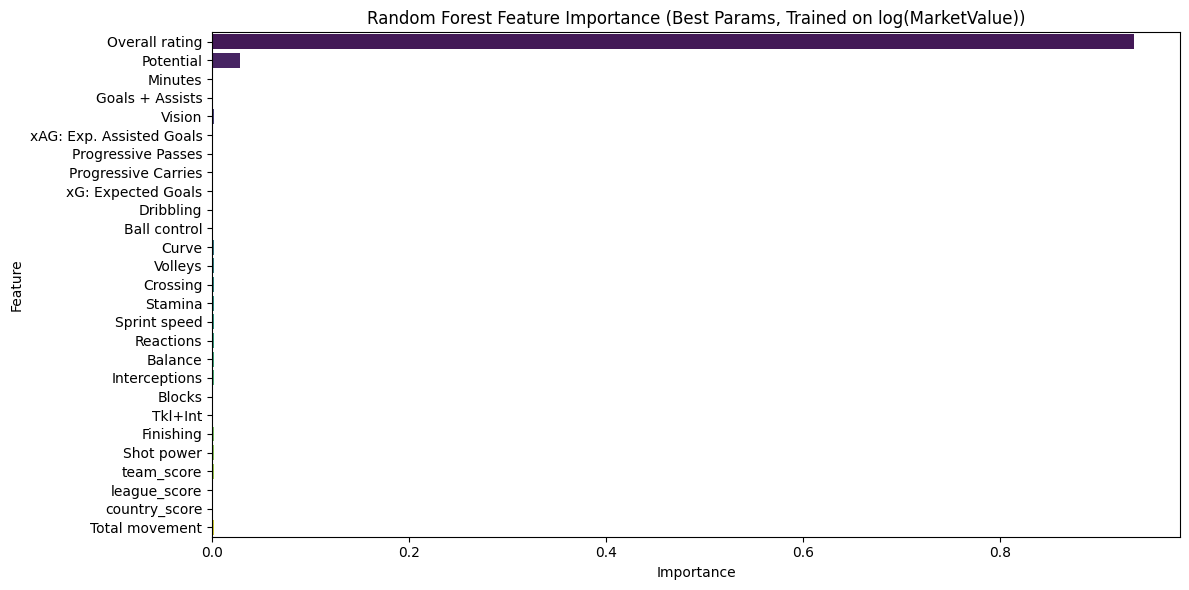

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Split X and log(y) into train/test
# ---------------------------------------------------
X = df_clean[selected_features]
y_raw = df_clean['MarketValue']       # raw €
y_log = np.log(df_clean['MarketValue'])  # log-transformed

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"✅ Data Split - X_train: {X_train.shape}, X_test: {X_test.shape}")

# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------

X_train_clean = X_train.drop(columns=['Value','Wage'])
X_test_clean  = X_test.drop(columns=['Value','Wage'])

# ---------------------------------------------------
# 3. Define and Train Random Forest (Best Fixed Parameters)
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=15,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300
)

rf_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred_log = rf_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate on log scale
# ---------------------------------------------------
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log))

print("\n📊 Random Forest Model Performance (LOG MarketValue):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE (log): {rmspe_log:.3f}%")

# ---------------------------------------------------
# 7. Back-transform predictions and evaluate on € scale
# ---------------------------------------------------
y_test_euros = np.exp(y_test_log)
y_pred_euros = np.exp(y_pred_log)

mae_euros = mean_absolute_error(y_test_euros, y_pred_euros)
mse_euros = mean_squared_error(y_test_euros, y_pred_euros)
rmse_euros = np.sqrt(mse_euros)
r2_euros = r2_score(y_test_euros, y_pred_euros)
rmspe_euros = rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros))

print("\n📊 Random Forest Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mae_euros:.3f}")
print(f"RMSE (€): {rmse_euros:.3f}")
print(f"R² (€): {r2_euros:.3f}")
print(f"RMSPE (€): {rmspe_euros:.3f}%")

# ---------------------------------------------------
# 8. Plot: Actual vs Predicted (€ scale)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Random Forest (Best Params, log-trained)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_best_params_logtrain.png"))
plt.show()

# ---------------------------------------------------
# 9. Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_best_params_logtrain.png"))
plt.show()


### 📊 Best Stacked Model Performance (Normal MarketValue €):
- MAE (€): 954,867
- RMSE (€): 1,859,923
- R²: 0.951
- RMSPE (€): 27.28%


📊 Best Stacked Model Performance (Normal MarketValue €):
MAE (€): 954,867
RMSE (€): 1,859,923
R²: 0.951
RMSPE (€): 27.28%


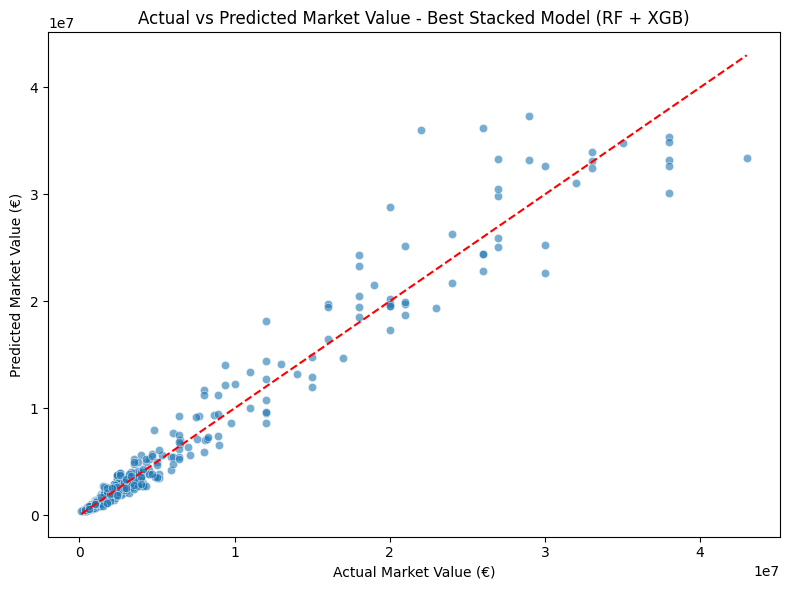

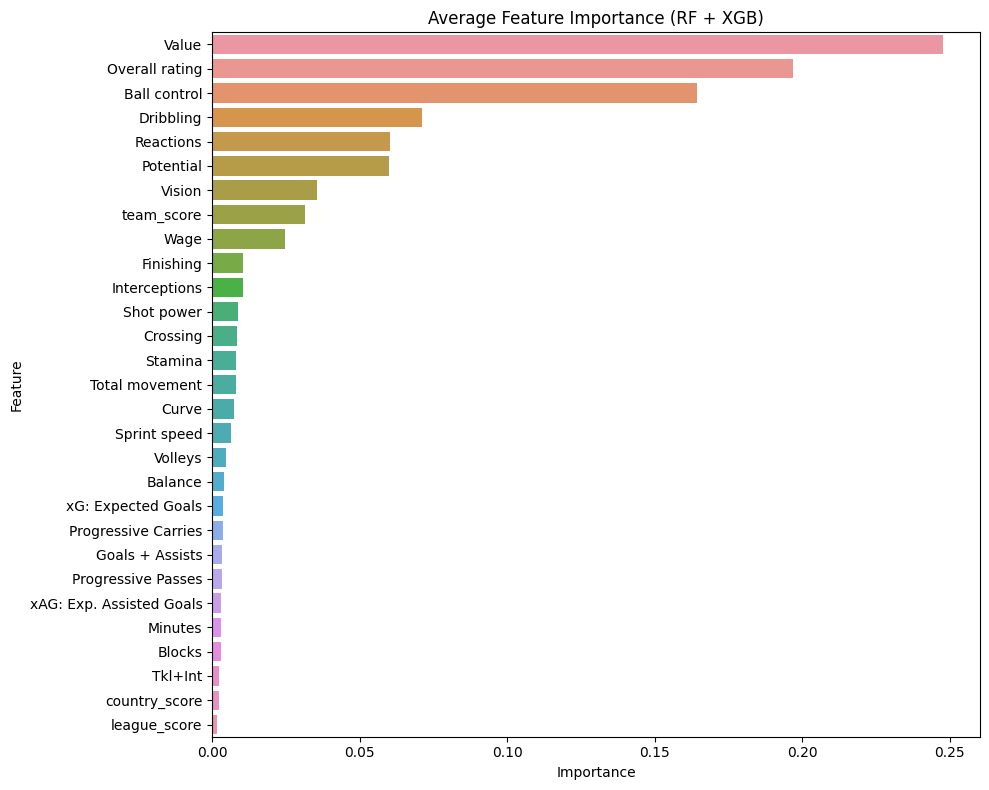

In [40]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Prepare Data (X and y for normal MarketValue)
# ---------------------------------------------------
X = df_clean[selected_features]
y = df_clean['MarketValue']  # normal €

# ---------------------------------------------------
# 2. Split into Train and Test sets
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------
# 3. Remove corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 4. Define Base Models with Best Params
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=0.9
)

# ---------------------------------------------------
# 5. Create Stacked Model
# ---------------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        RidgeCV()
    ),
    n_jobs=-1
)

# ---------------------------------------------------
# 6. Train Stacked Model
# ---------------------------------------------------
stacked_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 7. Predict
# ---------------------------------------------------
y_pred = stacked_model.predict(X_test_clean)

# ---------------------------------------------------
# 8. Define Metrics Helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 9. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 Best Stacked Model Performance (Normal MarketValue €):")
print(f"MAE (€): {mae:,.0f}")
print(f"RMSE (€): {rmse:,.0f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE (€): {rmspe_val:.2f}%")

# ---------------------------------------------------
# 10. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Best Stacked Model (RF + XGB)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_actual_vs_predicted_best_params.png"))
plt.show()

# ---------------------------------------------------
# 11. Plot Feature Importances
# ---------------------------------------------------
# Since feature importance is not defined for RidgeCV (only trees),
# we can average RF and XGB importances:
# ---------------------------------------------------
# 11. Plot Feature Importances (correctly from fitted models inside stacking)
# ---------------------------------------------------

# Access the fitted models
fitted_rf = stacked_model.named_estimators_['rf']
fitted_xgb = stacked_model.named_estimators_['xgb']

# Get importances
rf_importances = fitted_rf.feature_importances_
xgb_importances = fitted_xgb.feature_importances_

# Average them
avg_importances = (rf_importances + xgb_importances) / 2

# Create dataframe
feature_importances_df = pd.DataFrame({
    'Feature': X_train_clean.columns,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(data=feature_importances_df, y='Feature', x='Importance')
plt.title("Average Feature Importance (RF + XGB)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_feature_importance_best_params_fixed.png"))
plt.show()



In [42]:
# ---------------------------------------------------
# Print Sample of Actual vs Predicted Market Values
# ---------------------------------------------------
sample_results = pd.DataFrame({
    'Actual Market Value (€)': y_test.values,
    'Predicted Market Value (€)': np.round(y_pred).astype(int)
})

# Show first 15 rows (you can adjust)
print("\n🧪 Sample of Actual vs Predicted Market Values:")
print(sample_results.head(30))



🧪 Sample of Actual vs Predicted Market Values:
    Actual Market Value (€)  Predicted Market Value (€)
0                   1600000                     1334844
1                   1900000                     2377801
2                   4800000                     7972582
3                    900000                      901769
4                    640000                      508355
5                  16000000                    16464401
6                    320000                      487789
7                   1800000                     1255685
8                   1800000                     2099421
9                   3000000                     2585476
10                 30000000                    25233188
11                   870000                      965052
12                  2400000                     3669626
13                  5100000                     3805031
14                 19000000                    21506727
15                   500000                      718822


### 📊 Final Stacked Model Performance (LOG MarketValue):
- MAE (log): 0.186
- RMSE (log): 0.220
- R² (log): 0.966
- RMSPE (log): 1.51%

### 📊 Final Stacked Model Performance (MarketValue € back-transformed):
- MAE (€): 976,763
- RMSE (€): 1,892,288
- R² (€): 0.950
- RMSPE (€): 22.50%

✅ Data Split Done: X_train: (1524, 29), X_test: (382, 29)

📊 Final Stacked Model Performance (LOG MarketValue):
MAE (log): 0.186
RMSE (log): 0.220
R² (log): 0.966
RMSPE (log): 1.51%

📊 Final Stacked Model Performance (MarketValue € back-transformed):
MAE (€): 976,763
RMSE (€): 1,892,288
R² (€): 0.950
RMSPE (€): 22.50%


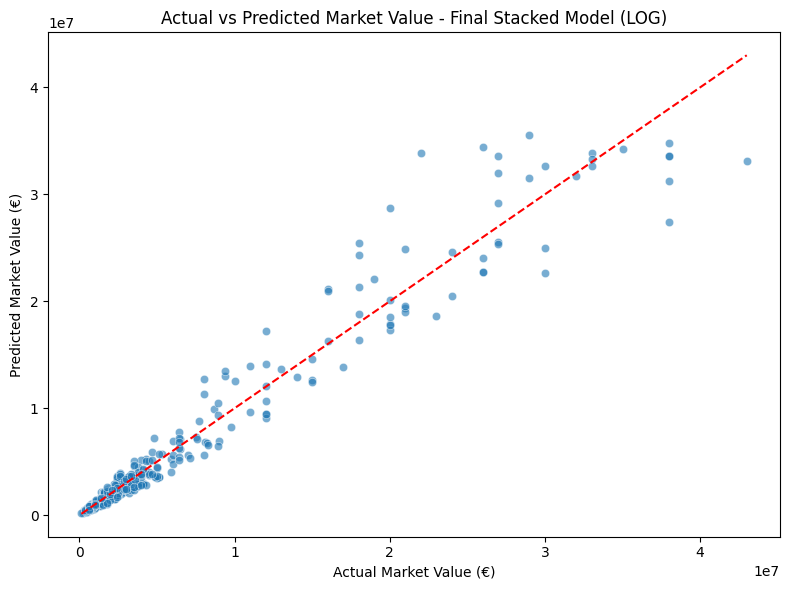

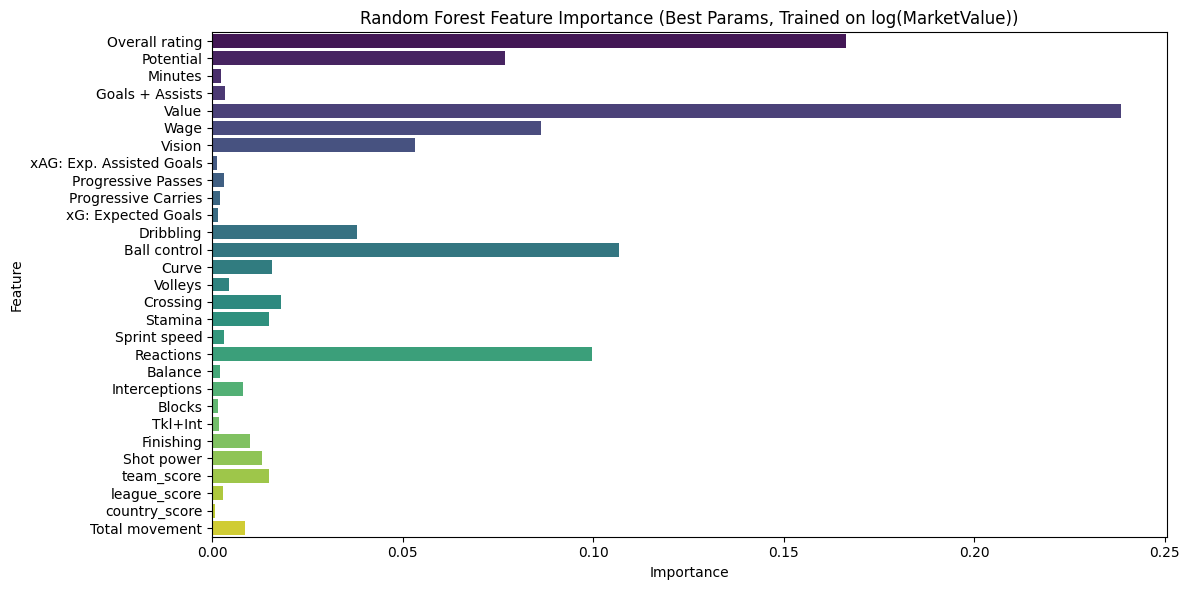

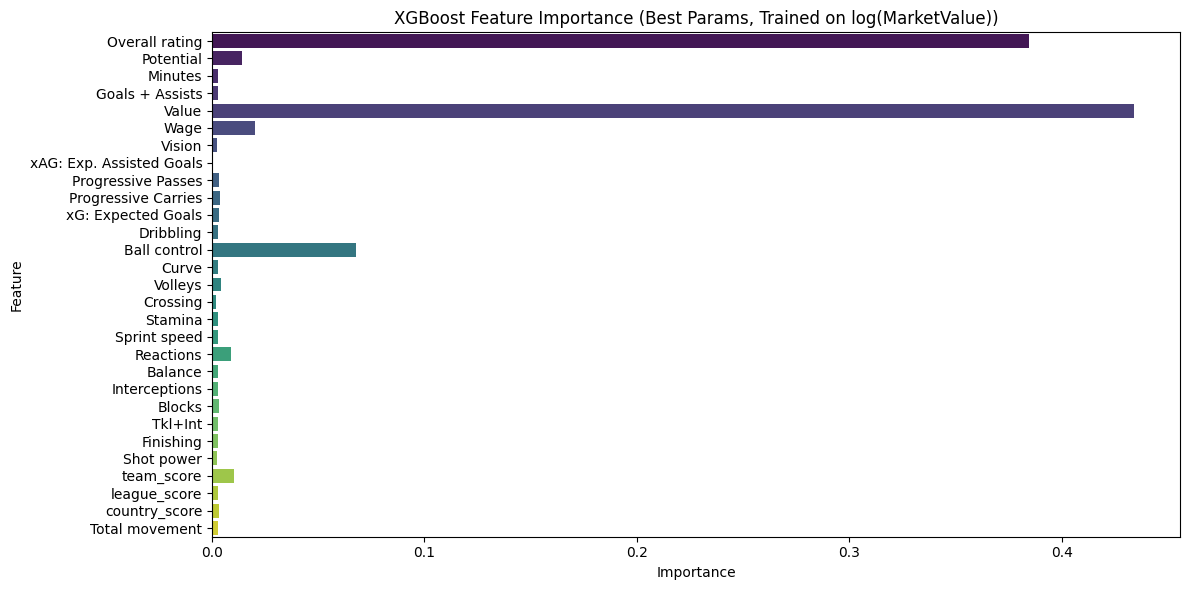

In [4]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Prepare Data (X and log(y))
# ---------------------------------------------------
X = df_clean[selected_features]
y = df_clean['MarketValue']  # normal €

# Transform target to log
y_log = np.log(y)

# ---------------------------------------------------
# 2. Split into Train and Test sets
# ---------------------------------------------------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"✅ Data Split Done: X_train: {X_train.shape}, X_test: {X_test.shape}")

# ---------------------------------------------------
# 3. Remove corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 4. Define Base Models with Best Params
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.9,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    subsample=0.9
)

# ---------------------------------------------------
# 5. Create Stacked Model
# ---------------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        RidgeCV()
    ),
    n_jobs=-1
)

# ---------------------------------------------------
# 6. Train Stacked Model
# ---------------------------------------------------
stacked_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 7. Predict
# ---------------------------------------------------
y_pred_log = stacked_model.predict(X_test_clean)

# Back-transform predictions
y_pred_euros = np.exp(y_pred_log)
y_test_euros = np.exp(y_test_log)

# ---------------------------------------------------
# 8. Define Metrics Helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 9. Evaluate
# ---------------------------------------------------
print("\n📊 Final Stacked Model Performance (LOG MarketValue):")
print(f"MAE (log): {mean_absolute_error(y_test_log, y_pred_log):.3f}")
print(f"RMSE (log): {np.sqrt(mean_squared_error(y_test_log, y_pred_log)):.3f}")
print(f"R² (log): {r2_score(y_test_log, y_pred_log):.3f}")
print(f"RMSPE (log): {rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log)):.2f}%")

print("\n📊 Final Stacked Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mean_absolute_error(y_test_euros, y_pred_euros):,.0f}")
print(f"RMSE (€): {np.sqrt(mean_squared_error(y_test_euros, y_pred_euros)):,.0f}")
print(f"R² (€): {r2_score(y_test_euros, y_pred_euros):.3f}")
print(f"RMSPE (€): {rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros)):.2f}%")

# ---------------------------------------------------
# 10. Plot: Actual vs Predicted (MarketValue €)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Final Stacked Model (LOG)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_actual_vs_predicted_final_log.png"))
plt.show()

# ---------------------------------------------------
# 11. Feature Importance Plots from Base Models (Consistent Theme)
# ---------------------------------------------------

# --- Random Forest Feature Importance ---
rf_importances = stacked_model.named_estimators_['rf'].feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(
    x=rf_importances,
    y=X_train_clean.columns,
    palette="viridis"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_best_params_logtrain.png"))
plt.show()

# --- XGBoost Feature Importance ---
xgb_importances = stacked_model.named_estimators_['xgb'].feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(
    x=xgb_importances,
    y=X_train_clean.columns,
    palette="viridis"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgb_best_params_logtrain.png"))
plt.show()


In [8]:
import pandas as pd
import numpy as np

# Use RMSPE in real MarketValue scale
rmspe_percent = 22.50  # in percent
rmspe_decimal = rmspe_percent / 100

# Re-read the original file to recover player names
original_df = pd.read_csv("/kaggle/input/mf-data/MF.csv")

# Merge names back using MarketValue and Value as keys (or add an ID column in preprocessing)
df_clean_with_names = df_clean.merge(
    original_df[['Name', 'MarketValue', 'Value']],
    on=['MarketValue', 'Value'],  # you can also use an ID if available
    how='left'
)

# Sample 5 diverse players
sample_df = pd.concat([
    df_clean_with_names[df_clean_with_names['MarketValue'] < 1e6].sample(1),
    df_clean_with_names[(df_clean_with_names['MarketValue'] >= 1e6) & (df_clean_with_names['MarketValue'] < 2e7)].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] >= 2e7].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] < df_clean_with_names['MarketValue'].median()].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] > df_clean_with_names['MarketValue'].median()].sample(1)
], ignore_index=True)

# Extract features and player names
sample_X = sample_df[selected_features]
player_names = sample_df['Name'].fillna('Unknown')
actual_values = sample_df['MarketValue'].values

# Predict in log scale → convert to €
log_preds = stacked_model.predict(sample_X)
predicted_values = np.exp(log_preds)

# Confidence intervals
lower_bounds = predicted_values * (1 - rmspe_decimal)
upper_bounds = predicted_values * (1 + rmspe_decimal)

# Final prediction table
results_df = pd.DataFrame({
    'Player': player_names,
    'Actual (€)': actual_values.astype(int),
    'Predicted (€)': predicted_values.astype(int),
    'Lower Bound (€)': lower_bounds.astype(int),
    'Upper Bound (€)': upper_bounds.astype(int)
})

# Display
print(f"\n🎯 Predicted Market Values with 90% Confidence Intervals (RMSPE = {rmspe_percent}%):")
print(results_df.to_string(index=False))



🎯 Predicted Market Values with 90% Confidence Intervals (RMSPE = 22.5%):
             Player  Actual (€)  Predicted (€)  Lower Bound (€)  Upper Bound (€)
          N. Chadli      600000         635444           492469           778419
            J. Hove     2500000        2883263          2234529          3531998
          M. Camara    33000000       31722060         24584596         38859523
Carlos Mendes Gomes     1200000        1426094          1105223          1746966
        S. Esposito     5000000        4411287          3418747          5403826


In [48]:
# ---------------------------------------------------
# 11. Build Prediction Intervals (90% Confidence)
# ---------------------------------------------------
# Define 85% confidence Z score
Z = 1.44  # for ~85% confidence

# RMSPE in percentage
rmspe_percent = 22.5  # from your model performance
rmspe_ratio = rmspe_percent / 100

# Calculate lower and upper bounds
lower_bound = y_pred_euros * (1 - Z * rmspe_ratio)
upper_bound = y_pred_euros * (1 + Z * rmspe_ratio)

# Clip lower bounds to avoid negative MarketValues
lower_bound = np.clip(lower_bound, 0, None)

# Create a dataframe for easy viewing
predicted_intervals_df = pd.DataFrame({
    'Actual (€)': y_test_euros.values.astype(int),
    'Predicted (€)': y_pred_euros.astype(int),
    'Lower Bound (€)': lower_bound.astype(int),
    'Upper Bound (€)': upper_bound.astype(int)
})

# Show first 10 results
print("\n🧠 Predicted Market Values with 90% Prediction Intervals:")
print(predicted_intervals_df.head(10))



🧠 Predicted Market Values with 90% Prediction Intervals:
   Actual (€)  Predicted (€)  Lower Bound (€)  Upper Bound (€)
0     1600000        1508187          1019534          1996839
1     1900000        2511423          1697722          3325125
2     4800000        7239264          4893742          9584785
3      900000         956308           646464          1266152
4      639999         494222           334094           654349
5    15999999       16317174         11030409         21603938
6      319999         439799           297304           582294
7     1799999        1218696           823838          1613554
8     1799999        2195398          1484089          2906707
9     3000000        2436841          1647305          3226378
